In [32]:
import string
import re
from numpy import array, argmax, random, take, delete
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', 200)

In [2]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

In [3]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [7]:
data = read_text("./data/deu-eng/deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [9]:
deu_eng = deu_eng[:50000,:]

In [11]:
deu_eng.shape

(50000, 3)

In [12]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [19]:
type(deu_eng)

numpy.ndarray

In [11]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    
    deu_eng[i,1] = deu_eng[i,1].lower()

In [21]:
deu_eng

array([['Go', 'Geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['We took a wrong turn', 'Wir sind falsch abgebogen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #823901 (jellorage) & #2112094 (freddy1)'],
       ['We traveled together', 'Wir waren zusammen auf Reisen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600396 (Pfirsichbaeumchen)'],
       ['We traveled together', 'Wir sind zusammen gereist',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600398 (Pfirsichbaeumchen)']],
      dtype='<U537')

In [36]:
deu_eng = delete(deu_eng, 2, 1)

In [37]:
deu_eng

array([['Go', 'Geh'],
       ['Hi', 'Hallo'],
       ['Hi', 'Grüß Gott'],
       ...,
       ['We took a wrong turn', 'Wir sind falsch abgebogen'],
       ['We traveled together', 'Wir waren zusammen auf Reisen'],
       ['We traveled together', 'Wir sind zusammen gereist']],
      dtype='<U537')

In [38]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    
    deu_eng[i,1] = deu_eng[i,1].lower()

In [39]:
deu_eng

array([['go', 'geh'],
       ['hi', 'hallo'],
       ['hi', 'grüß gott'],
       ...,
       ['we took a wrong turn', 'wir sind falsch abgebogen'],
       ['we traveled together', 'wir waren zusammen auf reisen'],
       ['we traveled together', 'wir sind zusammen gereist']],
      dtype='<U537')

In [40]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [41]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

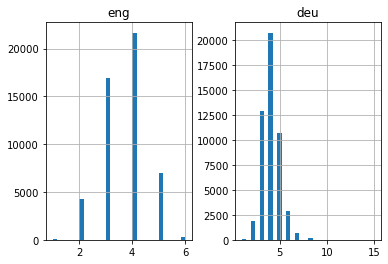

In [42]:
length_df.hist(bins = 30)
plt.show()

In [43]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [44]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6152


In [45]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10112


In [46]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

#### Model building

In [52]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [53]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [54]:
# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [55]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [56]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

/Users/jandas/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [57]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/30
63/63 [==============================] - 142s 2s/step - loss: 4.2819 - val_loss: 2.7946

Epoch 00001: val_loss improved from inf to 2.79464, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 2/30
63/63 [==============================] - 119s 2s/step - loss: 2.7203 - val_loss: 2.6917

Epoch 00002: val_loss improved from 2.79464 to 2.69172, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 3/30
63/63 [==============================] - 125s 2s/step - loss: 2.5747 - val_loss: 2.5269

Epoch 00003: val_loss improved from 2.69172 to 2.52694, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 4/30
63/63 [==============================] - 163s 3s/step - loss: 2.3994 - val_loss: 2.3858

Epoch 00004: val_loss improved from 2.52694 to 2.38577, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 5/30
63/63 [==============================] - 157s 2s/step - loss: 2.2532 - val_loss: 2.2648

Epoch 00005: val_loss improved from 2.38577 to 2.26480, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 6/30
63/63 [==============================] - 128s 2s/step - loss: 2.1097 - val_loss: 2.1997

Epoch 00006: val_loss improved from 2.26480 to 2.19966, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 7/30
63/63 [==============================] - 122s 2s/step - loss: 1.9890 - val_loss: 2.1153

Epoch 00007: val_loss improved from 2.19966 to 2.11526, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 8/30
63/63 [==============================] - 123s 2s/step - loss: 1.8687 - val_loss: 2.0108

Epoch 00008: val_loss improved from 2.11526 to 2.01083, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 9/30
63/63 [==============================] - 134s 2s/step - loss: 1.7745 - val_loss: 1.9444

Epoch 00009: val_loss improved from 2.01083 to 1.94443, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 10/30
63/63 [==============================] - 143s 2s/step - loss: 1.6685 - val_loss: 1.8822

Epoch 00010: val_loss improved from 1.94443 to 1.88216, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 11/30
63/63 [==============================] - 160s 3s/step - loss: 1.5803 - val_loss: 1.8097

Epoch 00011: val_loss improved from 1.88216 to 1.80966, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 12/30
63/63 [==============================] - 121s 2s/step - loss: 1.4801 - val_loss: 1.7296

Epoch 00012: val_loss improved from 1.80966 to 1.72957, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 13/30
63/63 [==============================] - 125s 2s/step - loss: 1.3943 - val_loss: 1.6775

Epoch 00013: val_loss improved from 1.72957 to 1.67752, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 14/30
63/63 [==============================] - 127s 2s/step - loss: 1.3028 - val_loss: 1.6416

Epoch 00014: val_loss improved from 1.67752 to 1.64165, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 15/30
63/63 [==============================] - 138s 2s/step - loss: 1.2178 - val_loss: 1.5820

Epoch 00015: val_loss improved from 1.64165 to 1.58200, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 16/30
63/63 [==============================] - 144s 2s/step - loss: 1.1384 - val_loss: 1.5370

Epoch 00016: val_loss improved from 1.58200 to 1.53699, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 17/30
63/63 [==============================] - 140s 2s/step - loss: 1.0687 - val_loss: 1.5005

Epoch 00017: val_loss improved from 1.53699 to 1.50046, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 18/30
63/63 [==============================] - 129s 2s/step - loss: 0.9991 - val_loss: 1.4808

Epoch 00018: val_loss improved from 1.50046 to 1.48084, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 19/30
63/63 [==============================] - 126s 2s/step - loss: 0.9336 - val_loss: 1.4447

Epoch 00019: val_loss improved from 1.48084 to 1.44468, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 20/30
63/63 [==============================] - 147s 2s/step - loss: 0.8692 - val_loss: 1.4022

Epoch 00020: val_loss improved from 1.44468 to 1.40224, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 21/30
63/63 [==============================] - 162s 3s/step - loss: 0.7986 - val_loss: 1.3862

Epoch 00021: val_loss improved from 1.40224 to 1.38617, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 22/30
63/63 [==============================] - 146s 2s/step - loss: 0.7529 - val_loss: 1.3576

Epoch 00022: val_loss improved from 1.38617 to 1.35756, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 23/30
63/63 [==============================] - 166s 3s/step - loss: 0.6899 - val_loss: 1.3488

Epoch 00023: val_loss improved from 1.35756 to 1.34882, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 24/30
63/63 [==============================] - 157s 2s/step - loss: 0.6384 - val_loss: 1.3341

Epoch 00024: val_loss improved from 1.34882 to 1.33408, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 25/30
63/63 [==============================] - 183s 3s/step - loss: 0.5878 - val_loss: 1.3139

Epoch 00025: val_loss improved from 1.33408 to 1.31391, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 26/30
63/63 [==============================] - 188s 3s/step - loss: 0.5423 - val_loss: 1.2838

Epoch 00026: val_loss improved from 1.31391 to 1.28376, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 27/30
63/63 [==============================] - 189s 3s/step - loss: 0.4945 - val_loss: 1.2931

Epoch 00027: val_loss did not improve from 1.28376
Epoch 28/30
63/63 [==============================] - 194s 3s/step - loss: 0.4602 - val_loss: 1.2766

Epoch 00028: val_loss improved from 1.28376 to 1.27660, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 29/30
63/63 [==============================] - 189s 3s/step - loss: 0.4189 - val_loss: 1.2909

Epoch 00029: val_loss did not improve from 1.27660
Epoch 30/30
63/63 [==============================] - 189s 3s/step - loss: 0.3840 - val_loss: 1.2618

Epoch 00030: val_loss improved from 1.27660 to 1.26177, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


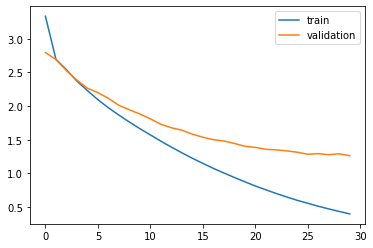

In [58]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [59]:
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/Users/jandas/opt/anaconda3/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [61]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [62]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [63]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [64]:
pd.set_option('display.max_colwidth', 200)

In [67]:
pred_df.tail(20)

,actual,predicted
9980,tom has betrayed us,tom betrayed us
9981,she smiled sadly,she smiled sad
9982,tom looks crushed,tom looks uneasy
9983,he went to the shop,he came
9984,he got well again,he kept abroad
9985,i saw you looking,i saw tom saw
9986,tom was so busy,tom was up of
9987,where could he be,where is be
9988,my friend was shot,my man was a
9989,come on trust me,come you me


In [68]:
pred_df.sample(15)

,actual,predicted
575,he is a dreamer,hes a grouch
3066,give tom a call,write tom a
5369,shes a cutie,shes a emotional
8749,my right leg hurts,my arm hurts
3408,we made waffles,we made a pizza
7653,i hate beans,i hate lawyers
2471,you need to grow up,speak up
276,theres no elevator,theres no
8707,what is tom eating,whats tom reading
9647,im not good at that,im not at


In [69]:
testX.reshape((testX.shape[0],testX.shape[1]))

array([[  36, 1639,   18, ...,    0,    0,    0],
       [1030,    5,   35, ...,    0,    0,    0],
       [   9,   25,   30, ...,    0,    0,    0],
       ...,
       [ 403,   26,    8, ...,   95,    0,    0],
       [   1, 9008,   28, ...,    0,    0,    0],
       [   3,    4,   31, ...,    0,    0,    0]], dtype=int32)

In [74]:
testX[1][7]

0